# Part 1

In [2]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
sns.set(style="darkgrid")

## Getting and Cleaning the Data

In [3]:
from urllib import request

def get_book(url):
    response = request.urlopen(url)
    return response.read().decode('utf8')
    
notes_from_underground_raw = get_book("http://www.gutenberg.org/files/600/600.txt")
crime_and_punishment_raw = get_book("http://www.gutenberg.org/files/2554/2554-0.txt")
the_idiot_raw = get_book("http://www.gutenberg.org/files/2638/2638-0.txt")
the_possessed_raw = get_book("http://www.gutenberg.org/files/8117/8117-0.txt")
the_brothers_karamazov_raw = get_book("http://www.gutenberg.org/files/28054/28054-0.txt")

In [4]:
import re

def get_book_contents(book_raw):
    start = re.compile(r"START OF (?:THE|THIS) PROJECT GUTENBERG", flags=re.IGNORECASE)
    end = re.compile(r"END OF (?:THE|THIS) PROJECT GUTENBERG", flags=re.IGNORECASE)
    
    book_start = start.search(book_raw)
    book_end = end.search(book_raw)
    return book_raw[book_start.span()[1]:book_end.span()[1]]
   
notes = get_book_contents(notes_from_underground_raw)
crime = get_book_contents(crime_and_punishment_raw)
idiot = get_book_contents(the_idiot_raw)
possessed = get_book_contents(the_possessed_raw)
brothers = get_book_contents(the_brothers_karamazov_raw)

In [5]:
import nltk

stop_words = nltk.corpus.stopwords.words('english')

def clean(book, stop_words):
    book = book.lower()
    #tokenizing
    book_tokens_clean = nltk.tokenize.RegexpTokenizer(r'\w+').tokenize(book)
    book_clean = pd.DataFrame(book_tokens_clean, columns = ['word'])
    #removing stop words
    book_clean = book_clean[~book_clean['word'].isin(stop_words)]
    #removing extraneous spaces
    book_clean['word'] = book_clean['word'].apply(lambda x: re.sub(' +', ' ', x))
    book_clean = book_clean[book_clean['word'].str.len() > 1]
    return book_clean

In [6]:
keep_words = ['no', 'not']
stop_words_context = [w for w in stop_words if w not in keep_words]
negations = ['not', 'no', 'never', 'without']

def bigram(book):
    book_context = clean(book, stop_words_context)
    book_bigrams = pd.DataFrame(list(nltk.bigrams(book_context['word'])), 
                                            columns = ['word1', 'word2'])
    return book_bigrams
    
notes_bigrams = bigram(notes)
crime_bigrams = bigram(crime)
idiot_bigrams = bigram(idiot)
possessed_bigrams = bigram(possessed)
brothers_bigrams = bigram(brothers)

## Sentiment analysis with the AFINN lexicon

In [7]:
from afinn import Afinn
afinn = Afinn()

def afinn_context(book_bigrams):
    book_bigrams['score'] = book_bigrams['word2'].apply(afinn.score)
    book_bigrams['score'] = book_bigrams.apply(
                            lambda x: x['score'] * -1 if x['word1'] in negations else x['score'], 
                            axis = 1)
    return book_bigrams
    
notes_afinn = afinn_context(notes_bigrams.copy())
crime_afinn = afinn_context(crime_bigrams.copy())
idiot_afinn = afinn_context(idiot_bigrams.copy())
possessed_afinn = afinn_context(possessed_bigrams.copy())
brothers_afinn = afinn_context(brothers_bigrams.copy())

In [8]:
def plot_afinn(df, title):
    i = 0
    scores = []
    while i < df.shape[0] - 500:
        scores.append(df.iloc[i:i + 500].loc[:, 'score'].sum())
        i += 500
        
    plt.plot(scores, c= np.random.rand(3,))
    plt.ylabel("AFINN score")
    plt.title(title)
    plt.xticks([])
    #y-axis limits were arrived at from the observed limits in the data. 
    #These should be changed if you're working with a different corpus.
    plt.ylim(top = 165, bottom = -165)
    plt.axhline(y = 0, color = 'gray')
    plt.show()

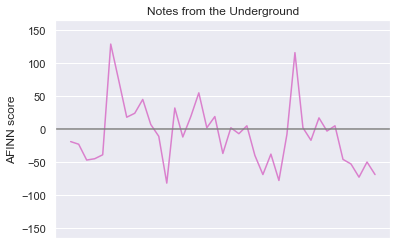

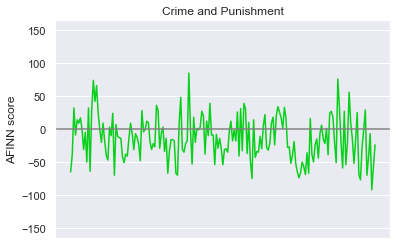

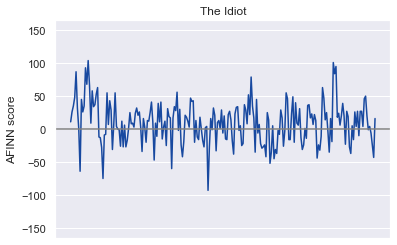

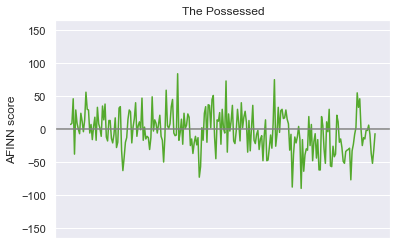

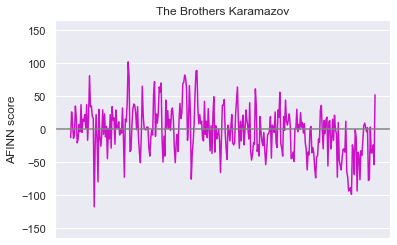

In [9]:
plot_afinn(notes_afinn, "Notes from the Underground")
plot_afinn(crime_afinn, "Crime and Punishment")
plot_afinn(idiot_afinn, "The Idiot")
plot_afinn(possessed_afinn, "The Possessed")
plot_afinn(brothers_afinn, "The Brothers Karamazov")

In [10]:
afinn_means= [notes_afinn['score'].mean(),
          crime_afinn['score'].mean(),
          idiot_afinn['score'].mean(),
          possessed_afinn['score'].mean(),
          brothers_afinn['score'].mean()]

titles = ["Notes from the Underground",
         "Crime and Punishment",
         "The Idiot",
         "The Possessed",
         "The Brothers Karamazov"]

afinn_mean_df = pd.DataFrame(np.array([titles, afinn_means]).T, columns = ['book', 'mean score'])

print("\nMean AFINN Scores:\n", afinn_mean_df)
print("\nMean of AFINN mean scores:", afinn_mean_df['mean score'].astype('float').mean())


Mean AFINN Scores:
                          book             mean score
0  Notes from the Underground  -0.015224032586558045
1        Crime and Punishment  -0.027444888297085367
2                   The Idiot   0.018184701591161388
3               The Possessed  -0.008277181598868647
4      The Brothers Karamazov  -0.006399990144384763

Mean of AFINN mean scores: -0.007832278207147086


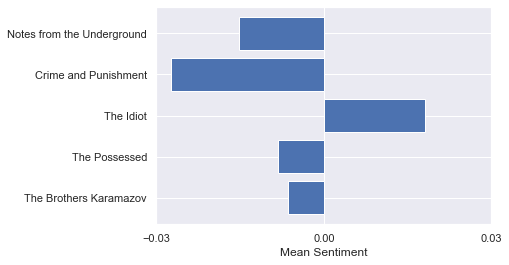

In [11]:
afinn_mean_df = afinn_mean_df.iloc[::-1]

plt.barh(afinn_mean_df['book'], afinn_mean_df['mean score'].astype('float'))
plt.xticks([-0.03, 0, 0.03])
plt.xlabel("Mean Sentiment")
plt.show()

## Sentiment analysis with the NRC lexicon

In [12]:
NRC = pd.read_csv(r"C:\Users\josht\Documents\353\project\NRC.csv",  names=["word", "sentiment", "classifaction"])
NRC_sentiments = ['anger', 'anticipation', 'disgust', 'fear', 'joy', 'negative', 'positive', 'sadness', 'suprise', 'trust']

def nrc_classify(word):
    return NRC[NRC['word'] == word].loc[:, 'classifaction'].tolist()

def nrc_clean(book_nrc):
    book_nrc['classifications'] = book_nrc['word2'].apply(nrc_classify)
    book_nrc = book_nrc[book_nrc['classifications'].str.len() > 0]
    
    classification_df = pd.DataFrame.from_dict(dict(book_nrc['classifications'])).transpose()
    classification_df.columns = NRC_sentiments
    
    book_nrc = book_nrc.join(classification_df)
    book_nrc = book_nrc.drop(['classifications'], axis = 1)
    return book_nrc

def nrc_context(book_bigrams):
    for e in NRC_sentiments:
        book_bigrams[e] = book_bigrams.apply(
                                        lambda x: x[e] * -1 if x['word1'] in negations else x[e], 
                                        axis = 1)

In [15]:
notes_nrc = nrc_clean(notes_bigrams.copy())
crime_nrc = nrc_clean(crime_bigrams.copy())
idiot_nrc = nrc_clean(idiot_bigrams.copy())
possessed_nrc = nrc_clean(possessed_bigrams.copy())
brothers_nrc = nrc_clean(brothers_bigrams.copy())

nrc_context(notes_nrc)
nrc_context(crime_nrc)
nrc_context(idiot_nrc)
nrc_context(possessed_nrc)
nrc_context(brothers_nrc)

In [29]:
def plot_nrc(df, title):
    i = 0
    j = 0
    scores = pd.DataFrame(np.zeros((df.shape[0] // 750, 10)), columns = NRC_sentiments)

    while i < df.shape[0] - 750:
        scores.iloc[j] = df.loc[i:i + 750, 'anger':'trust'].sum()
        i += 750
        j += 1
    
    grid_kws = {"height_ratios": (.9, .05), "hspace": .2}
    f, (ax, cbar_ax) = plt.subplots(2, gridspec_kw=grid_kws, figsize=(10,3))
    ax = sns.heatmap(scores.transpose(), 
                 ax=ax,
                 cbar_ax=cbar_ax,
                 cbar_kws={"orientation": "horizontal", "label" : "Number of words conveying sentiment"},
                 linewidths = 0.01,
                 xticklabels = False,
                 vmin = 0,
                 vmax = 125).set_title(title)

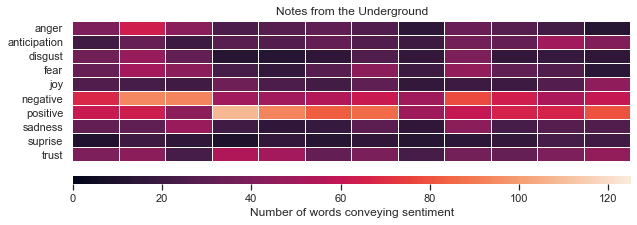

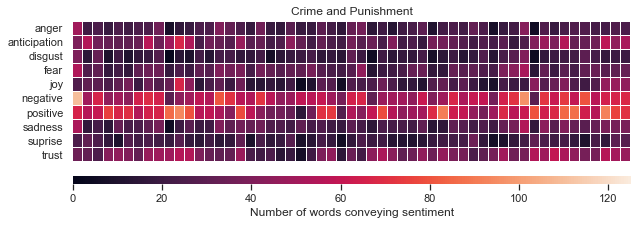

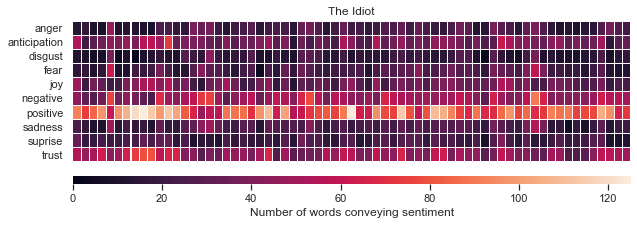

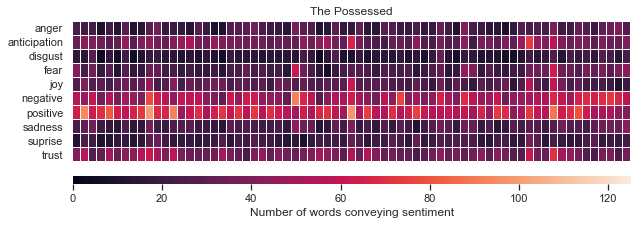

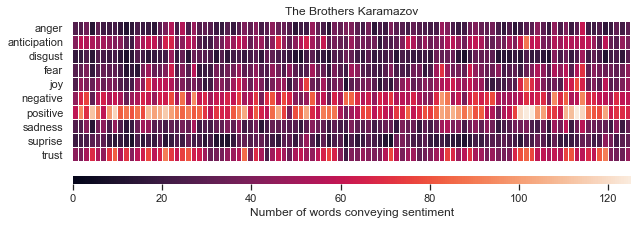

In [30]:
plot_nrc(notes_nrc, "Notes from the Underground")
plot_nrc(crime_nrc, "Crime and Punishment")
plot_nrc(idiot_nrc, "The Idiot")
plot_nrc(possessed_nrc, "The Possessed")
plot_nrc(brothers_nrc, "The Brothers Karamazov")

In [31]:
print("\nNotes from the Underground NRC means:\n", notes_nrc.loc[:, 'anger':'trust'].mean())
print("\nCrime and Punishment NRC means:\n", crime_nrc.loc[:, 'anger':'trust'].mean())
print("\nThe Idiot NRC means:\n",idiot_nrc.loc[:, 'anger':'trust'].mean())
print("\nThe Possessed NRC means:\n", possessed_nrc.loc[:, 'anger':'trust'].mean())
print("\nThe Brothers Karamazov NRC means:\n", brothers_nrc.loc[:, 'anger':'trust'].mean())


Notes from the Underground NRC means:
 anger           0.091250
anticipation    0.100176
disgust         0.072845
fear            0.094666
joy             0.086180
negative        0.192638
positive        0.188120
sadness         0.089597
suprise         0.054111
trust           0.108221
dtype: float64

Crime and Punishment NRC means:
 anger           0.080312
anticipation    0.110585
disgust         0.062507
fear            0.096681
joy             0.082131
negative        0.186900
positive        0.180367
sadness         0.095269
suprise         0.062795
trust           0.116855
dtype: float64

The Idiot NRC means:
 anger           0.068775
anticipation    0.113977
disgust         0.050991
fear            0.078172
joy             0.097423
negative        0.158664
positive        0.249623
sadness         0.080293
suprise         0.064354
trust           0.135944
dtype: float64

The Possessed NRC means:
 anger           0.072890
anticipation    0.108052
disgust         0.051200
fear  

# Part 2

## Machine Learning with the NRC lexicon

In [ ]:
notes_tokens = nltk.word_tokenize(notes)
crime_tokens = nltk.word_tokenize(crime)
idiot_tokens = nltk.word_tokenize(idiot)
possessed_tokens = nltk.word_tokenize(possessed)
brothers_tokens = nltk.word_tokenize(brothers)

notes_str = " ".join(notes_tokens)
notes_sentences = notes_str.split(".")

crime_str = " ".join(crime_tokens)
crime_sentences = crime_str.split(".")

idiot_str = " ".join(idiot_tokens)
idiot_sentences = idiot_str.split(".")

possessed_str = " ".join(possessed_tokens)
possessed_sentences = possessed_str.split(".")

brothers_str = " ".join(brothers_tokens)
brothers_sentences = brothers_str.split(".")

sentences = pd.Series(notes_sentences + crime_sentences + idiot_sentences \
            + possessed_sentences + brothers_sentences)

sentences = sentences[sentences.apply(lambda x: len(x) > 1)]

np.random.seed(2020)
to_label_train = sentences.iloc[np.random.randint(0, len(sentences), 100)]

np.random.seed(42)
to_label_test = sentences.iloc[np.random.randint(0, len(sentences), 30)]
#In hindsight, I've realized there many cleaner alternatives to the above 5 lines. 
#One of which would be to use Skilearn's train_test_split function.

In [ ]:
#Save the test and training sets to CSVs to be labelled

to_label_train.to_csv("to_label_train.csv")
to_label_test.to_csv("to_label_test.csv")

In [ ]:
labelled_train = pd.read_csv("labelled_train.csv")
labelled_train.columns = ['line', 'sentence', 'score']

labelled_train = pd.read_csv("labelled_test.csv")
labelled_test.columns = ['line', 'sentence', 'score']

In [ ]:
def clean_labelled(sentence, stop_words):
    sentence = sentence.lower()
    sentence_tokens_clean = nltk.tokenize.RegexpTokenizer(r'\w+').\
                                                tokenize(sentence)
    
    sentence_clean = pd.DataFrame(sentence_tokens_clean, columns = ['word'])
    sentence_clean = [w for w in sentence_tokens_clean \
                      if w not in stop_words] 

    return sentence_clean

labelled_train['sentence'] = labelled_train['sentence'].\
    apply(lambda x:clean_labelled(x, stop_words_context))

labelled_test['sentence'] = labelled_test['sentence'].\
    apply(lambda x:clean_labelled(x, stop_words_context))

def nrc_sentence(sentence):
    total = np.zeros(10)
    
    for word in sentence:
        nrc = nrc_classify(word)
        if(len(nrc) > 0): total = np.add(total, nrc)
        
    return total
    
labelled_train['classification'] = labelled_train['sentence'].\
                                            apply(nrc_sentence)
labelled_test['classification'] = labelled_test['sentence'].\
                                        apply(nrc_sentence)

def labelled_adjust_class(labelled):
    classification_df = pd.DataFrame.from_dict( \
        dict(labelled['classification'])).transpose()
    
    classification_df.columns = NRC_sentiments
    
    labelled = labelled.join(classification_df)
    labelled = labelled.drop(['classification'], axis = 1)
    return labelled

labelled_train = labelled_adjust_class(labelled_train)
labelled_test = labelled_adjust_class(labelled_test)

In [ ]:
from sklearn.ensemble import AdaBoostClassifier
model = AdaBoostClassifier(n_estimators=70, random_state=0)

model.fit(labelled_train.loc[:, 'anger':'trust'],
          labelled_train.loc[:, 'score'])

print("\nTraining score: ", model.score( \
    labelled_train.loc[:, 'anger':'trust'], 
            labelled_train.loc[:, 'score']))

print("\nValidation score: ", model.score( \
        labelled_test.loc[:, 'anger':'trust'], 
                labelled_test.loc[:, 'score']))

In [ ]:
def predict_sentences(book, stop_words):
    #Break up book into sentences
    book_sentences = pd.DataFrame(book.split("."), columns = ['sentence'])
    
    #Clean sentences
    book_sentences['sentence'] = book_sentences['sentence'].\
        apply(lambda x: clean_labelled(x, stop_words))
    
    book_sentences = book_sentences[book_sentences['sentence'].\
                                    str.len() > 0] 
    
    book_sentences['classification'] = book_sentences['sentence'].\
                                                apply(nrc_sentence)
    
    #Adjust classifications
    book_sentences_adjusted = labelled_adjust_class(book_sentences)
    book_sentences_adjusted.index = np.arange(0, 
                    book_sentences_adjusted.shape[0])
    
    #Predict sentences' sentiment
    book_sentences_score = pd.concat([book_sentences_adjusted, pd.Series( \
            model.predict(book_sentences_adjusted.loc[:, 'anger':'trust']))], 
                                                             axis = 1)
    
    book_sentences_score = book_sentences_score.rename( \
                        columns = {0 : 'sentence_score'})
    
    return book_sentences_score


In [ ]:
notes_sentece_predictions = predict_sentences(notes, stop_words_context)
crime_sentece_predictions = predict_sentences(crime, stop_words_context)
idiot_sentece_predictions = predict_sentences(idiot, stop_words_context)
possessed_sentece_predictions = predict_sentences(possessed, stop_words_context)
brothers_sentece_predictions = predict_sentences(brothers, stop_words_context)

In [ ]:
def plot_sentence(df, title):
    i = 0
    scores = []
    while i < df.shape[0] - 50:
        scores.append(df.iloc[i:i + 50]['sentence_score'].sum())
        i += 50
        
    plt.plot(scores, c=np.random.rand(3,))
    plt.ylabel("Sentement of Sentences")
    plt.title(title)
    plt.xticks([])
    plt.ylim(top = 35, bottom = -35)
    plt.axhline(y = 0, color = 'gray')
    plt.show()


In [ ]:
plot_sentence(notes_sentece_predictions, "Notes from the Underground")
plot_sentence(crime_sentece_predictions, "Crime and Punishment")
plot_sentence(idiot_sentece_predictions, "The Idiot")
plot_sentence(possessed_sentece_predictions, "The Possessed")
plot_sentence(brothers_sentece_predictions, "The Brothers Karamazov")

## Statistical Inference with the AFINN Lexicon

In [ ]:
from bs4 import BeautifulSoup

def get_contents(tag):
    return tag.contents[1] 

titles = pd.Series(dtype = "string")

#Loops through each webpage in the goodreads list
for i in np.arange(1, 12):
    url = "https://www.goodreads.com/list/show/16.Best_Books_of_the_19th_Century?page=" + str(i)
    page = request.urlopen(url)
    soup = BeautifulSoup(page, "html.parser")
    page_titles = pd.Series(soup.find_all(class_ = "bookTitle"))
    page_titles = page_titles.apply(get_contents)
    titles = titles.append(page_titles)

In [ ]:
#Goodreads has over 50 pages of titles of Dostoevsky books. 
#All significant titles are on the first two pages.

page1_url = "https://www.goodreads.com/author/list/3137322.Fyodor_Dostoyevsky?page=1&per_page=30"
page2_url = "https://www.goodreads.com/author/list/3137322.Fyodor_Dostoyevsky?page=2&per_page=30"

page1 = request.urlopen(page1_url)
page2 = request.urlopen(page2_url)

page1_soup = BeautifulSoup(page1, "html.parser")
page2_soup = BeautifulSoup(page2, "html.parser")

dostoyevsky_titles = pd.Series(page1_soup.find_all(class_ = "bookTitle"))
dostoyevsky_titles = dostoyevsky_titles.append(pd.Series(page2_soup.find_all(class_ = "bookTitle")))

dostoyevsky_titles = dostoyevsky_titles.apply(get_contents)

titles = titles[~ titles.isin(dostoyevsky_titles)]

In [ ]:
np.random.seed(0)
sample_titles = titles.iloc[np.random.choice(titles.shape[0], size=60, replace=False)]

In [ ]:
owl_creek_bridge_url = "http://www.gutenberg.org/files/375/375.txt"
owl_creek_bridge_response = request.urlopen(owl_creek_bridge_url)
owl_creek_bridge_raw = owl_creek_bridge_response.read().decode('utf8')

portrait_of_a_lady_vol1_url = "http://www.gutenberg.org/files/2833/2833.txt"
portrait_of_a_lady_vol1_response = request.urlopen(portrait_of_a_lady_vol1_url)
portrait_of_a_lady_vol1_raw = portrait_of_a_lady_vol1_response.read().decode('utf8')

portrait_of_a_lady_vol2_url = "http://www.gutenberg.org/files/2834/2834.txt"
portrait_of_a_lady_vol2_response = request.urlopen(portrait_of_a_lady_vol2_url)
portrait_of_a_lady_vol2_raw = portrait_of_a_lady_vol2_response.read().decode('utf8')

portrait_of_a_lady_raw = portrait_of_a_lady_vol2_raw + portrait_of_a_lady_vol1_raw


white_company_url = "http://www.gutenberg.org/files/903/903.txt"
white_company_response = request.urlopen(white_company_url)
white_company_raw = white_company_response.read().decode('utf8')

ladies_paradise_url = "http://www.gutenberg.org/files/54726/54726-0.txt"
ladies_paradise_response = request.urlopen(ladies_paradise_url)
ladies_paradise_raw = ladies_paradise_response.read().decode('utf8')

private_memoirs_url = "http://www.gutenberg.org/files/2276/2276.txt"
private_memoirs_response = request.urlopen(private_memoirs_url)
private_memoirs_raw = private_memoirs_response.read().decode('utf8')

master_of_ballantrae_url = "http://www.gutenberg.org/files/864/864-0.txt"
master_of_ballantrae_response = request.urlopen(master_of_ballantrae_url)
master_of_ballantrae_raw = master_of_ballantrae_response.read().decode('utf8')

agathas_husband_url = "http://www.gutenberg.org/files/21767/21767.txt"
agathas_husband_response = request.urlopen(agathas_husband_url)
agathas_husband_raw = agathas_husband_response.read().decode('utf8')

schoolboys_story_url = "https://www.gutenberg.org/files/1467/1467-h/1467-h.htm#page55"
schoolboys_story_response = request.urlopen(schoolboys_story_url)
schoolboys_story_raw = schoolboys_story_response.read().decode('utf8')

descent_of_man_url = "http://www.gutenberg.org/cache/epub/2300/pg2300.txt"
descent_of_man_response = request.urlopen(descent_of_man_url)
descent_of_man_raw = descent_of_man_response.read().decode('utf8')

scarlet_letter_url = "https://www.gutenberg.org/files/25344/25344-h/25344-h.htm"
scarlet_letter_response = request.urlopen(scarlet_letter_url)
scarlet_letter_raw = scarlet_letter_response.read().decode('utf8')

letters_from_hawaii_url = "http://www.gutenberg.org/files/3193/3193-h/3193-h.htm#2H_4_0009"
letters_from_hawaii_response = request.urlopen(letters_from_hawaii_url)
letters_from_hawaii_raw = letters_from_hawaii_response.read().decode('utf8')

story_of_an_african_farm_url =  "http://www.gutenberg.org/files/1441/1441.txt"
story_of_an_african_farm_response = request.urlopen(story_of_an_african_farm_url)
story_of_an_african_farm_raw = story_of_an_african_farm_response.read().decode('utf8')

summer_in_a_garden_url =  "http://www.gutenberg.org/files/3135/3135-0.txt"
summer_in_a_garden_response = request.urlopen(summer_in_a_garden_url)
summer_in_a_garden_raw = summer_in_a_garden_response.read().decode('utf8')

#Les Chants de Maldoror is not available

trilby_url = "https://www.gutenberg.org/files/39858/39858-h/39858-h.htm#page_211"
trilby_response = request.urlopen(trilby_url)
trilby_raw = trilby_response.read().decode('utf8')

woman_of_thirty_url = "http://www.gutenberg.org/files/1950/1950.txt"
woman_of_thirty_response = request.urlopen(woman_of_thirty_url)
woman_of_thirty_raw = woman_of_thirty_response.read().decode('utf8')

#Frau Jenny Treibel not available


general_WT_Sherman_url = "http://www.gutenberg.org/cache/epub/4361/pg4361.txt"
general_WT_Sherman_response = request.urlopen(general_WT_Sherman_url)
general_WT_Sherman_raw = general_WT_Sherman_response.read().decode('utf8')


#Ruslan and Ludmila not available

#La Petite Fadette not available


last_of_the_mohicans_url = "http://www.gutenberg.org/files/940/940.txt"
last_of_the_mohicans_response = request.urlopen(last_of_the_mohicans_url)
last_of_the_mohicans_raw = last_of_the_mohicans_response.read().decode('utf8')

rough_rider_url = "http://www.gutenberg.org/files/13000/13000.txt"
rough_rider_response = request.urlopen(rough_rider_url)
rough_rider_raw = rough_rider_response.read().decode('utf8')

how_to_tell_a_story_url = "http://www.gutenberg.org/files/3250/3250-0.txt"
how_to_tell_a_story_response = request.urlopen(how_to_tell_a_story_url)
how_to_tell_a_story_raw = how_to_tell_a_story_response.read().decode('utf8')

pan_tadeusz_url = "http://www.gutenberg.org/files/28240/28240-0.txt"
pan_tadeusz_response = request.urlopen(pan_tadeusz_url)
pan_tadeusz_raw = pan_tadeusz_response.read().decode('utf8')

rob_roy_url = "http://www.gutenberg.org/files/7025/7025.txt"
rob_roy_response = request.urlopen(rob_roy_url)
rob_roy_raw = rob_roy_response.read().decode('utf8')

water_babies_url = "http://www.gutenberg.org/files/1018/1018-0.txt"
water_babies_response = request.urlopen(water_babies_url)
water_babies_raw = water_babies_response.read().decode('utf8')

resurrection_url = "http://www.gutenberg.org/files/1938/1938.txt"
resurrection_response = request.urlopen(resurrection_url)
resurrection_raw = resurrection_response.read().decode('utf8')

ruth_url = "http://www.gutenberg.org/files/4275/4275-h/4275-h.htm"
ruth_response = request.urlopen(ruth_url)
ruth_raw = ruth_response.read().decode('utf8')

Emily_Dickinson_poems_url = "http://www.gutenberg.org/cache/epub/12242/pg12242.txt"
Emily_Dickinson_poems_response = request.urlopen(Emily_Dickinson_poems_url)
Emily_Dickinson_poems_raw = Emily_Dickinson_poems_response.read().decode('utf8')

man_that_corrupted_hadleyburg_url = "https://www.gutenberg.org/files/1213/1213-h/1213-h.htm"
man_that_corrupted_hadleyburg_response = request.urlopen(man_that_corrupted_hadleyburg_url)
man_that_corrupted_hadleyburg_raw = man_that_corrupted_hadleyburg_response.read().decode('utf8')

carmen_url = "http://www.gutenberg.org/files/2465/2465-0.txt"
carmen_response = request.urlopen(carmen_url)
carmen_raw = carmen_response.read().decode('utf8')

jane_eyre_url = "https://www.gutenberg.org/files/1260/1260-h/1260-h.htm"
jane_eyre_response = request.urlopen(jane_eyre_url)
jane_eyre_raw = jane_eyre_response.read().decode('utf8')

ladys_life_in_the_rocky_mountains_url = "http://www.gutenberg.org/files/755/755.txt"
ladys_life_in_the_rocky_mountains_response = request.urlopen(ladys_life_in_the_rocky_mountains_url)
ladys_life_in_the_rocky_mountains_raw = ladys_life_in_the_rocky_mountains_response.read().decode('utf8')

history_of_the_conquest_of_peru_url = "http://www.gutenberg.org/files/1209/1209.txt"
history_of_the_conquest_of_peru_response = request.urlopen(history_of_the_conquest_of_peru_url)
history_of_the_conquest_of_peru_raw = history_of_the_conquest_of_peru_response.read().decode('utf8')

red_fairy_book_url = "http://www.gutenberg.org/files/540/540.txt"
red_fairy_book_response = request.urlopen(red_fairy_book_url)
red_fairy_book_raw = red_fairy_book_response.read().decode('utf8')

cask_of_amontillado_url = "http://www.gutenberg.org/files/1063/1063.txt"
cask_of_amontillado_response = request.urlopen(cask_of_amontillado_url)
cask_of_amontillado_raw = cask_of_amontillado_response.read().decode('utf8')

taras_bulba_url = "http://www.gutenberg.org/files/1197/1197.txt"
taras_bulba_response = request.urlopen(taras_bulba_url)
taras_bulba_raw = taras_bulba_response.read().decode('utf8')

#L'Art d'être grand-père is unavailable

canon_alberics_scrap_book_url = "https://gutenberg.ca/ebooks/james-alberic2/james-alberic2-00-h.html"
canon_alberics_scrap_book_response = request.urlopen(canon_alberics_scrap_book_url)
canon_alberics_scrap_book_raw = canon_alberics_scrap_book_response.read().decode('utf8')

under_the_greenwood_tree_url = "http://www.gutenberg.org/files/2662/2662.txt"
under_the_greenwood_tree_response = request.urlopen(under_the_greenwood_tree_url)
under_the_greenwood_tree_raw = under_the_greenwood_tree_response.read().decode('utf8')

war_and_peace_url = "http://www.gutenberg.org/files/2600/2600-0.txt"
war_and_peace_response = request.urlopen(war_and_peace_url)
war_and_peace_raw = war_and_peace_response.read().decode('utf8')

sense_and_sensibility_url =  "http://www.gutenberg.org/files/161/161.txt"
sense_and_sensibility_response = request.urlopen(sense_and_sensibility_url)
sense_and_sensibility_raw = sense_and_sensibility_response.read().decode('utf8')

#Mahomet and His Successors Part 2 is unavailable

annabel_lee_url =  "http://www.gutenberg.org/files/43624/43624.txt"
annabel_lee_response = request.urlopen(annabel_lee_url)
annabel_lee_raw = annabel_lee_response.read().decode('utf8')

life_of_Charlotte_Brontë_vol1_url =  "http://www.gutenberg.org/files/1827/1827.txt"
life_of_Charlotte_Brontë_vol1_response = request.urlopen(life_of_Charlotte_Brontë_vol1_url)
life_of_Charlotte_Brontë_vol1_raw = life_of_Charlotte_Brontë_vol1_response.read().decode('utf8')

life_of_Charlotte_Brontë_vol2_url =  "http://www.gutenberg.org/files/1700/1700.txt"
life_of_Charlotte_Brontë_vol2_response = request.urlopen(life_of_Charlotte_Brontë_vol2_url)
life_of_Charlotte_Brontë_vol2_raw = life_of_Charlotte_Brontë_vol2_response.read().decode('utf8')

life_of_Charlotte_Brontë_raw = life_of_Charlotte_Brontë_vol1_raw + life_of_Charlotte_Brontë_vol2_raw 


hero_of_our_time_url =  "http://www.gutenberg.org/files/913/913.txt"
hero_of_our_time_response = request.urlopen(hero_of_our_time_url)
hero_of_our_time_raw = hero_of_our_time_response.read().decode('utf8')

#The Marquise of O— and Other Stories is unavailable

les_misérables_url = "http://www.gutenberg.org/files/135/135-0.txt"
les_misérables_response = request.urlopen(les_misérables_url)
les_misérables_raw = les_misérables_response.read().decode('utf8')

miss_cayleys_adventures_url = "http://www.gutenberg.org/files/30970/30970.txt"
miss_cayleys_adventures_response = request.urlopen(miss_cayleys_adventures_url)
miss_cayleys_adventures_raw = miss_cayleys_adventures_response.read().decode('utf8')

statism_and_anarchy_url = "http://www.gutenberg.org/files/30506/30506-h/30506-h.htm"
statism_and_anarchy_response = request.urlopen(statism_and_anarchy_url)
statism_and_anarchy_raw = statism_and_anarchy_response.read().decode('utf8')

#The Semi-Attached Couple & The Semi-Detached is unavailble

rachel_ray_url = "http://www.gutenberg.org/files/34000/34000.txt"
rachel_ray_response = request.urlopen(rachel_ray_url)
rachel_ray_raw = rachel_ray_response.read().decode('utf8')

what_christmas_is_as_we_grow_older_url = "https://www.gutenberg.org/files/1467/1467-h/1467-h.htm"
what_christmas_is_as_we_grow_older_response = request.urlopen(what_christmas_is_as_we_grow_older_url)
what_christmas_is_as_we_grow_older_raw = what_christmas_is_as_we_grow_older_response.read().decode('utf8')

books_raw = [owl_creek_bridge_raw,
            portrait_of_a_lady_raw,
            white_company_raw,
            ladies_paradise_raw,
            private_memoirs_raw,
            master_of_ballantrae_raw,
            agathas_husband_raw,
            schoolboys_story_raw,
            descent_of_man_raw,
            scarlet_letter_raw,
            letters_from_hawaii_raw,
            story_of_an_african_farm_raw, 
            summer_in_a_garden_raw,
            trilby_raw,
            woman_of_thirty_raw,
            general_WT_Sherman_raw,
            last_of_the_mohicans_raw,
            rough_rider_raw,
            how_to_tell_a_story_raw,
            pan_tadeusz_raw,
            rob_roy_raw,
            water_babies_raw,
            resurrection_raw,
            ruth_raw,
            Emily_Dickinson_poems_raw,
            man_that_corrupted_hadleyburg_raw,
            carmen_raw,
            jane_eyre_raw,
            history_of_the_conquest_of_peru_raw,
            red_fairy_book_raw,
            cask_of_amontillado_raw,
            #canon_alberics_scrap_book_raw - causeing troubles parsing
            taras_bulba_raw,
            war_and_peace_raw,
            sense_and_sensibility_raw,
            annabel_lee_raw,
            life_of_Charlotte_Brontë_raw,
            hero_of_our_time_raw,
            les_misérables_raw,
            miss_cayleys_adventures_raw,
            statism_and_anarchy_raw,
            rachel_ray_raw,
            what_christmas_is_as_we_grow_older_raw
            ]


In [ ]:
books_raw = pd.Series(books_raw)

books = books_raw.apply(get_book_contents)

books_bigrams = books.apply(bigram)

In [ ]:
books_afinn = books_bigrams.apply(afinn_context)

books_means = books_afinn.apply(lambda x: x['score'].mean())

In [ ]:
print(books_means.min(), books_means.max(), books_means.mean(), books_means.std())

In [ ]:
from scipy import stats
print("\np-value from normal test on sample: ", 
      stats.normaltest(books_means).pvalue)

In [ ]:
Dostoevsky_means= [notes_afinn['score'].mean(),
          crime_afinn['score'].mean(),
          idiot_afinn['score'].mean(),
          possessed_afinn['score'].mean(),
          brothers_afinn['score'].mean()]

titles = ["Notes from the Underground",
         "Crime and Punishment",
         "The Idiot",
         "The Possessed",
         "The Brothers Karamazov"]

Dostoevsky_mean_df = pd.DataFrame(np.array([titles, Dostoevsky_means]).T, 
                                     columns = ['book', 'mean score'])

Dostoevsky_mean_df['mean score'] = Dostoevsky_mean_df['mean score'].\
                                                    astype('float')

In [ ]:
import statsmodels.api as sm

Dostoevsky_mean_df['pvalue'] = Dostoevsky_mean_df['mean score'].apply(
            lambda x: sm.stats.ztest(books_means, value = x, 
                                 alternative = "larger")[1])

print("\np-values for each book: \n", Dostoevsky_mean_df)